#### **1. Import Libraries and Load Data**

In [789]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

Libraries imported successfully!


In [790]:
url = 'https://raw.githubusercontent.com/cheryvmak/Dataset-Repo/refs/heads/main/Data_files/home_loan_train.csv'
train_data = pd.read_csv(url)
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [791]:
# copy and Read in data
df1 = train_data.copy()

# Inspect dataset
df1.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [792]:
#Just an identifier — adds no predictive value.
df1 = df1.drop(columns=['Loan_ID'])
df1.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


#### **2. EDA-Based Data Quality Assessment**

Based on EDA findings, let's assess the specific issues identified

In [793]:
# Create a copy for preprocessing
df_processed = df1.copy()



# 1. Check for missing values (EDA showed no missing values)
print("\n1. Missing Values:")
missing_values = df_processed.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found (as expected from EDA)")

# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df_processed))*100:.2f}%")

# 3. Check skewness for variables identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
for var in skewed_vars:
    if var in df_processed.columns:
        skewness = df_processed[var].skew()
        #print(f"{var}: skewness = {skewness:.3f} ("f"{'strongly right-skewed' if skewness > 0.7 else 'not strongly skewed'})")
        #skewness = skew(df_processed[var])
        print(f"{var}: skewness = {skewness:.3f} "
      f"({'strongly skewed' if abs(skewness) > 0.7 else 'moderately skewed' if abs(skewness) > 0.3 else 'approximately normal'})")
  


1. Missing Values:
Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

2. Duplicate Rows:
Number of duplicate rows: 0

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: skewness = 6.540 (strongly skewed)
CoapplicantIncome: skewness = 7.492 (strongly skewed)
LoanAmount: skewness = 2.678 (strongly skewed)


#### **3. Handle Duplicates**

In [794]:
# Remove duplicates if any (EDA didn't report duplicates, but let's be thorough)
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
    print("✓ No duplicates to remove (as expected from EDA)")

✓ No duplicates to remove (as expected from EDA)


##### **4. Handling Missing Values**

In [795]:
# lets chexck for missing value
df_processed.isna().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [796]:
# Now lets handle the missing values

# lets iomport the imputer library
from sklearn.impute import SimpleImputer

In [797]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [798]:
# Prints and returns all categorical columns in the DataFrame.
numerical_features = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical Features:\n{numerical_features}")

Numerical Features:
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


In [799]:
# Prints and returns all categorical columns in the DataFrame.
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical Features:\n{categorical_features}")

Categorical Features:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


In [800]:
# Lets create an instance of the imputer class using "median" as strategy for imputation
num_imputer = SimpleImputer(strategy="median")

# Lets create an instance of the imputer class using "most_frequent" as strategy for imputation
cat_imputer = SimpleImputer(strategy="most_frequent")

In [801]:
# Lets apply the defined instances above
df_processed[numerical_features] = num_imputer.fit_transform(df_processed[numerical_features])
df_processed[categorical_features] = cat_imputer.fit_transform(df_processed[categorical_features])

In [802]:
# lets chexck for missing value
df_processed.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

#### **4. Log-Transform Skewed Variables (EDA Recommendation)**

Based on EDA findings, transform the right-skewed variables identified

In [803]:
# Log-transform skewed variables as recommended by EDA
print("=== LOG-TRANSFORMING SKEWED VARIABLES ===")
print("EDA identified these variables as right-skewed and recommended log transformation:")

# Variables to log-transform based on EDA findings
skewed_vars = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

for var in skewed_vars:
    if var in df_processed.columns:
        # Check if variable has zero or negative values
        min_val = df_processed[var].min()
        if min_val <= 0:
            # Use log1p for variables with zeros
            df_processed[f'{var}_log'] = np.log1p(df_processed[var])
            print(f"✓ {var}: Applied log1p transformation (had {min_val:.3f} minimum value)")
        else:
            # Use log for positive values only
            df_processed[f'{var}_log'] = np.log(df_processed[var])
            print(f"✓ {var}: Applied log transformation")
        
        # Check skewness before and after
        original_skew = skew(df_processed[var])
        transformed_skew = skew(df_processed[f'{var}_log'])
        print(f"  Original skewness: {original_skew:.3f} → Transformed skewness: {transformed_skew:.3f}")

print(f"\nDataset shape after log transformation: {df_processed.shape}")
print("New log-transformed columns:", [col for col in df_processed.columns if '_log' in col])


=== LOG-TRANSFORMING SKEWED VARIABLES ===
EDA identified these variables as right-skewed and recommended log transformation:
✓ ApplicantIncome: Applied log transformation
  Original skewness: 6.524 → Transformed skewness: 0.478
✓ CoapplicantIncome: Applied log1p transformation (had 0.000 minimum value)
  Original skewness: 7.473 → Transformed skewness: -0.173
✓ LoanAmount: Applied log transformation
  Original skewness: 2.736 → Transformed skewness: -0.195

Dataset shape after log transformation: (614, 15)
New log-transformed columns: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log']


##### **2. Handling Outliers**

In [804]:
# from scipy import stats
# # Outlier treatment based on EDA recommendations
# print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
# print("EDA recommended IQR-capping for  to preserve data points")

# # Define columns to cap
# cap_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

# # Compute z-scores only for selected columns
# z_scores = pd.DataFrame(stats.zscore(df1[cap_features]), columns=cap_features, index=df1.index)

# # Define Z-score threshold
# threshold = 3

# # Apply capping
# for col in cap_features:
#     # Identify non-outlier bounds
#     non_outliers = df1.loc[np.abs(z_scores[col]) <= threshold, col]
    
#     # Use non-outlier min/max as caps
#     lower_cap = non_outliers.min()
#     upper_cap = non_outliers.max()
    
#     # Count outliers
#     n_outliers = np.sum(np.abs(z_scores[col]) > threshold)
#     outlier_pct = (n_outliers / len(df1)) * 100
    
#     # Cap the column values
#     df1[col] = df1[col].clip(lower=lower_cap, upper=upper_cap)
    
#     print(f"{col}: capped {n_outliers} outliers ({outlier_pct:.2f}%) "
#           f"between [{lower_cap:.2f}, {upper_cap:.2f}]")

# print("\nOutlier capping completed for selected numeric features.")

In [805]:
# Outlier treatment based on EDA recommendations
print("=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===")
print("EDA recommended IQR-capping for  to preserve data points")

# Define numerical columns (excluding target)
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
if 'Loan_Statis' in numerical_cols:
    numerical_cols.remove('Loan_Status')

print(f"Treating outliers in {len(numerical_cols)} numerical features...")

# Apply IQR-capping method
outliers_capped = 3
for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers before capping
    outliers_before = ((df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)).sum()
    
    if outliers_before > 3:
        # Cap outliers
        df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
        df_processed[col] = np.where(df_processed[col] > upper_bound, upper_bound, df_processed[col])
        outliers_capped += outliers_before
        print(f"✓ {col}: Capped {outliers_before} outliers")

print(f"\nTotal outliers capped: {outliers_capped}")
print(f"Dataset shape after outlier treatment: {df_processed.shape}")


=== OUTLIER TREATMENT (IQR-CAPPING METHOD) ===
EDA recommended IQR-capping for  to preserve data points
Treating outliers in 3 numerical features...
✓ ApplicantIncome: Capped 50 outliers
✓ CoapplicantIncome: Capped 18 outliers
✓ LoanAmount: Capped 41 outliers

Total outliers capped: 112
Dataset shape after outlier treatment: (614, 15)


##### **3. Correcting inconsistencies**

In [806]:
# Replace '3+' with a number
df_processed['Dependents'] = df_processed['Dependents'].replace('3+', '3')

# Convert the column to numeric
df_processed['Dependents'] = df_processed['Dependents'].astype(int)


df_processed['Loan_Amount_Term'] = df_processed['Loan_Amount_Term'].astype(int)

df_processed


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log
0,Male,No,0,Graduate,No,5849.0,0.0,128.0,360,1.0,Urban,Y,8.674026,0.000000,4.852030
1,Male,Yes,1,Graduate,No,4583.0,1508.0,128.0,360,1.0,Rural,N,8.430109,7.319202,4.852030
2,Male,Yes,0,Graduate,Yes,3000.0,0.0,66.0,360,1.0,Urban,Y,8.006368,0.000000,4.189655
3,Male,Yes,0,Not Graduate,No,2583.0,2358.0,120.0,360,1.0,Urban,Y,7.856707,7.765993,4.787492
4,Male,No,0,Graduate,No,6000.0,0.0,141.0,360,1.0,Urban,Y,8.699515,0.000000,4.948760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900.0,0.0,71.0,360,1.0,Rural,Y,7.972466,0.000000,4.262680
610,Male,Yes,3,Graduate,No,4106.0,0.0,40.0,180,1.0,Rural,Y,8.320205,0.000000,3.688879
611,Male,Yes,1,Graduate,No,8072.0,240.0,253.0,360,1.0,Urban,Y,8.996157,5.484797,5.533389
612,Male,Yes,2,Graduate,No,7583.0,0.0,187.0,360,1.0,Urban,Y,8.933664,0.000000,5.231109


##### **4. Encoding(like label encoding and one-hot encoding)**

In [807]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 614 non-null    object 
 1   Married                614 non-null    object 
 2   Dependents             614 non-null    int64  
 3   Education              614 non-null    object 
 4   Self_Employed          614 non-null    object 
 5   ApplicantIncome        614 non-null    float64
 6   CoapplicantIncome      614 non-null    float64
 7   LoanAmount             614 non-null    float64
 8   Loan_Amount_Term       614 non-null    int64  
 9   Credit_History         614 non-null    float64
 10  Property_Area          614 non-null    object 
 11  Loan_Status            614 non-null    object 
 12  ApplicantIncome_log    614 non-null    float64
 13  CoapplicantIncome_log  614 non-null    float64
 14  LoanAmount_log         614 non-null    float64
dtypes: flo

In [808]:
def preprocess_loan_data(df):
    # Label Encoding (binary columns)
    label_map = {
        'Gender': {'Male': 1, 'Female': 0},
        'Married': {'Yes': 1, 'No': 0},
        'Education': {'Graduate': 1, 'Not Graduate': 0},
        'Self_Employed': {'Yes': 1, 'No': 0},
        'Loan_Status': {'Y': 1, 'N': 0}
    }

    for col, mapping in label_map.items():
        df[col] = df[col].map(mapping)

    # One-hot encoding for Property_Area
    df = pd.get_dummies(df, columns=['Property_Area'], drop_first=False, dtype=int)

    print("\nPreprocessing complete.")
    return df

In [809]:
df_preprocessed = preprocess_loan_data(df_processed)
df_preprocessed.head()


Preprocessing complete.


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0,1,0,5849.0,0.0,128.0,360,1.0,1,8.674026,0.000000,4.852030,0,0,1
1,1,1,1,1,0,4583.0,1508.0,128.0,360,1.0,0,8.430109,7.319202,4.852030,1,0,0
2,1,1,0,1,1,3000.0,0.0,66.0,360,1.0,1,8.006368,0.000000,4.189655,0,0,1
3,1,1,0,0,0,2583.0,2358.0,120.0,360,1.0,1,7.856707,7.765993,4.787492,0,0,1
4,1,0,0,1,0,6000.0,0.0,141.0,360,1.0,1,8.699515,0.000000,4.948760,0,0,1


#### **6. Feature Engineering**

In [810]:
# Create Total Income, a single feature representing total family earning power.
# Loan eligibility often depends on household income, not individual.
df_preprocessed['TotalIncome'] = df_preprocessed['ApplicantIncome'] + df_preprocessed['CoapplicantIncome']

# Measures ability to repay loan relative to loan amount.
# This helps model to differentiate between high earners taking small vs large loans
df_preprocessed['Income_Loan_Ratio'] = df_preprocessed['TotalIncome'] / (df_preprocessed['LoanAmount'] + 1)

#Interaction Features
#New relationships that might affect loan approval

#family responsibility effect
df_preprocessed['Married_Dependents'] = df_preprocessed['Married'] * df_preprocessed['Dependents']
# self-employed graduates might differ in credit risk
df_preprocessed['Education_SelfEmp'] = df_preprocessed['Education'] * df_preprocessed['Self_Employed']


print(f"\nDataset shape after feature engineering: {df_preprocessed.shape}")
print(f"New engineered features: {[col for col in df_preprocessed.columns if col not in df_processed.columns]}")


Dataset shape after feature engineering: (614, 21)
New engineered features: ['Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban', 'TotalIncome', 'Income_Loan_Ratio', 'Married_Dependents', 'Education_SelfEmp']


##### **4. Feature Scaling(Normalization / Standardization)**

In [811]:
# # lets import the scaling libraries
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # Lets standardize the dataset

# # lets create a copy of our dataset
# standardize_features = df_preprocessed.copy()

# # create an instance of the standardScaler class
# scaler = StandardScaler()

# # But I am applying it to the whole dataset
# standard_features = scaler.fit_transform(standardize_features)
# print(standard_features)

#### **6. Feature Selection**

Based on EDA correlation analysis, select high-signal features and evaluate low-signal ones

In [812]:
print("=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===")

# Separate features and target
X = df_preprocessed.drop('Loan_Status', axis=1)
y = df_preprocessed['Loan_Status']

print(f"Total features available: {X.shape[1]}")

# ---- EDA-based correlation signals ----
# High-signal (|corr| > 0.1)
high_signal_features = [
    'Credit_History', 
    'Property_semiurban', 
    'Property_rural', 
    'Married', 
    'Education'
]

# Low-signal (|corr| < 0.05)
low_signal_features = [
    'ApplicantIncome', 
    'CoapplicantIncome', 
    'Self_Employed', 
    'Loan_Amount_Term'
]

# Check actual availability in data
available_high_signal = [f for f in high_signal_features if f in X.columns]
available_low_signal = [f for f in low_signal_features if f in X.columns]

print(f"\nAvailable high-signal features: {available_high_signal}")
print(f"Available low-signal features: {available_low_signal}")

# ---- Feature sets ----
print("\n=== FEATURE SETS FOR EVALUATION ===")

# Set 1: All features except low-signal
features_exclude_low_signal = [col for col in X.columns if col not in available_low_signal]
print(f"Set 1 - Excluding low-signal features: {len(features_exclude_low_signal)} features")

# Set 2: High-signal + engineered features (if exist)
engineered_features = [
    col for col in X.columns 
    if any(keyword in col.lower() for keyword in ['total', 'ratio', 'interaction', 'log'])
]
high_signal_plus_engineered = available_high_signal + engineered_features
print(f"Set 2 - High-signal + engineered: {len(high_signal_plus_engineered)} features")

# Set 3: All features (baseline)
all_features = list(X.columns)
print(f"Set 3 - All features: {len(all_features)} features")

# Recommended: Set 2 (High-signal + Engineered)
selected_features = high_signal_plus_engineered
print(f"\n✓ Selected feature set for modeling: {len(selected_features)} features")
print("Selected features:", selected_features)


=== FEATURE SELECTION BASED ON EDA CORRELATION EVIDENCE ===
Total features available: 20

Available high-signal features: ['Credit_History', 'Married', 'Education']
Available low-signal features: ['ApplicantIncome', 'CoapplicantIncome', 'Self_Employed', 'Loan_Amount_Term']

=== FEATURE SETS FOR EVALUATION ===
Set 1 - Excluding low-signal features: 16 features
Set 2 - High-signal + engineered: 8 features
Set 3 - All features: 20 features

✓ Selected feature set for modeling: 8 features
Selected features: ['Credit_History', 'Married', 'Education', 'ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'TotalIncome', 'Income_Loan_Ratio']


##### **4. Data Splitting**

In [813]:
# Stratified data splitting based on EDA findings about class imbalance
print("=== STRATIFIED DATA SPLITTING ===")
print("EDA identified class imbalance - using stratified splitting to preserve class distribution")

# Select the chosen features
X_selected = X[selected_features]
print(f"Selected features shape: {X_selected.shape}")

# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 75% train, 25% validation (of the 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\nData split results:")
print(f"Training set: {X_train.shape} ({(X_train.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Validation set: {X_val.shape} ({(X_val.shape[0]/len(X_selected))*100:.1f}%)")
print(f"Test set: {X_test.shape} ({(X_test.shape[0]/len(X_selected))*100:.1f}%)")

# Check class distribution in each set (should be similar due to stratification)
print(f"\nClass distribution verification:")
print("Training set quality distribution:")
print(y_train.value_counts().sort_index())
print("\nValidation set quality distribution:")
print(y_val.value_counts().sort_index())
print("\nTest set quality distribution:")
print(y_test.value_counts().sort_index())


=== STRATIFIED DATA SPLITTING ===
EDA identified class imbalance - using stratified splitting to preserve class distribution
Selected features shape: (614, 8)

Data split results:
Training set: (368, 8) (59.9%)
Validation set: (123, 8) (20.0%)
Test set: (123, 8) (20.0%)

Class distribution verification:
Training set quality distribution:
Loan_Status
0    115
1    253
Name: count, dtype: int64

Validation set quality distribution:
Loan_Status
0    39
1    84
Name: count, dtype: int64

Test set quality distribution:
Loan_Status
0    38
1    85
Name: count, dtype: int64


#### **9. Feature Scaling**

Apply StandardScaler as recommended by EDA for distance-based models.

In [814]:
# Apply StandardScaler as recommended by EDA
print("=== FEATURE SCALING (STANDARD SCALER) ===")
print("EDA recommended StandardScaler for distance-based models")

# Fit scaler on training data only (to avoid data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✓ Scaling applied successfully!")
print(f"Training set scaled - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")
print(f"Validation set scaled - Mean: {X_val_scaled.mean().mean():.4f}, Std: {X_val_scaled.std().mean():.4f}")
print(f"Test set scaled - Mean: {X_test_scaled.mean().mean():.4f}, Std: {X_test_scaled.std().mean():.4f}")

# Verify scaling worked correctly
print(f"\nScaling verification:")
print(f"Training set - Mean ≈ 0: {abs(X_train_scaled.mean().mean()) < 0.01}")
print(f"Training set - Std ≈ 1: {abs(X_train_scaled.std().mean() - 1) < 0.01}")


=== FEATURE SCALING (STANDARD SCALER) ===
EDA recommended StandardScaler for distance-based models
✓ Scaling applied successfully!
Training set scaled - Mean: -0.0000, Std: 1.0014
Validation set scaled - Mean: -0.0571, Std: 0.9743
Test set scaled - Mean: -0.0345, Std: 1.0234

Scaling verification:
Training set - Mean ≈ 0: True
Training set - Std ≈ 1: True


#### **10. Feature Importance Analysis**

Analyze the importance of engineered features based on EDA recommendations.

=== FEATURE IMPORTANCE ANALYSIS ===
Top 10 features by correlation with Loan_Status:
 1. ApplicantIncome_log: 0.168
 2. LoanAmount_log: 0.117
 3. CoapplicantIncome_log: 0.107
 4. TotalIncome: 0.096
 5. Income_Loan_Ratio: 0.059
 6. Education: 0.048
 7. Credit_History: 0.020
 8. Married: 0.017

Engineered features in top 10: ['ApplicantIncome_log', 'CoapplicantIncome_log', 'LoanAmount_log', 'TotalIncome', 'Income_Loan_Ratio']


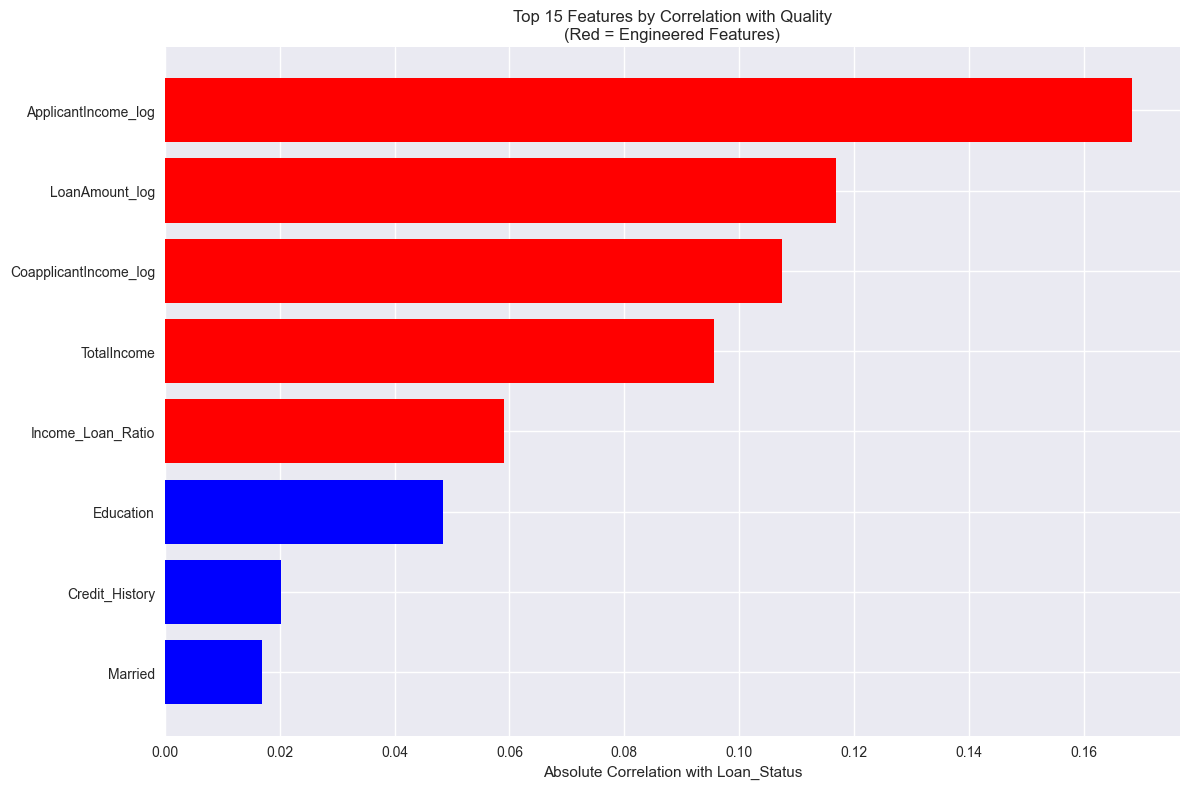


✓ Feature importance analysis completed
✓ 5 engineered features in top 10


In [815]:
# Feature importance analysis to validate EDA-based engineering
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Calculate correlation with target for all features
feature_correlations = X_train_scaled.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with Loan_Status:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(), 1):
    print(f"{i:2d}. {feature}: {corr:.3f}")

# Check if engineered features are among top features
engineered_features = [col for col in X_train_scaled.columns if any(keyword in col.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log'])]
print(f"\nEngineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Loan_Status')
plt.title('Top 15 Features by Correlation with Quality\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")


#### **11. Save Preprocessed Data**

In [816]:
print("SAVING PREPROCESSED DATA ")

# Save scaled datasets
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_val_scaled.to_csv('X_val_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# Save preprocessing objects
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selected_features, 'selected_features.pkl')

# Save feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_correlations.index,
    'correlation': feature_correlations.values
})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df1.shape,
    'final_shape': df_processed.shape,
    'selected_features': selected_features,
    'engineered_features': engineered_features,
    'train_samples': X_train_scaled.shape[0],
    'val_samples': X_val_scaled.shape[0],
    'test_samples': X_test_scaled.shape[0],
    'scaling_method': 'StandardScaler',
    'outlier_treatment': 'IQR_capping',
    'log_transformed': ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv")
print("- y_train.csv, y_val.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")


SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- X_train_scaled.csv, X_val_scaled.csv, X_test_scaled.csv
- y_train.csv, y_val.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


#### **12. Preprocessing Summary**

In [817]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df1.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(selected_features)}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Validation samples: {X_val_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")

print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, duplicates handled)")
print("> Log-transformation of skewed variables (ApplicantIncome', 'CoapplicantIncome', 'LoanAmount)")
print("> Outlier treatment using IQR-capping method")
print("> Feature engineering based on EDA recommendations:")
print("  - FA_to_VA_ratio (fixed acidity / volatile acidity)")
print("  - citric_over_total_acid (citric acid / total acidity)")
print("  - alcohol_acid_interaction (alcohol / volatile acidity)")
print("  - alcohol_density_ratio (alcohol / density)")
print("  - sulphate_citric_interaction (sulphates * citric acid)")
print("  - total_acidity (sum of all acidity measures)")
print("  - ph_acidity_balance (pH * total acidity)")
print("> Feature selection (high-signal features + engineered features)")
print("> Stratified data splitting (preserves class distribution)")
print("> StandardScaler applied (EDA recommendation for distance-based models)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")

print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> High-signal features prioritized: alcohol, volatile acidity, sulphates, citric acid")
print("> Low-signal features excluded: residual sugar, free sulfur dioxide")
print("> Skewed variables log-transformed as recommended")
print("> Acidity ratios created based on grouped means analysis")
print("> Alcohol-acidity interactions based on trivariate analysis")
print("> Fermentation efficiency features based on density-alcohol relationship")


print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")


.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (614, 12)
Final processed dataset shape: (614, 15)
Selected features: 8
Training samples: 368
Validation samples: 123
Test samples: 123

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, duplicates handled)
> Log-transformation of skewed variables (ApplicantIncome', 'CoapplicantIncome', 'LoanAmount)
> Outlier treatment using IQR-capping method
> Feature engineering based on EDA recommendations:
  - FA_to_VA_ratio (fixed acidity / volatile acidity)
  - citric_over_total_acid (citric acid / total acidity)
  - alcohol_acid_interaction (alcohol / volatile acidity)
  - alcohol_density_ratio (alcohol / density)
  - sulphate_citric_interaction (sulphates * citric acid)
  - total_acidity (sum of all acidity measures)
  - ph_acidity_balance (pH * total acidity)
> Feature selection (high-signal features + engineered features)
> Stratified data splitting (preserves class d